1. Loading the Data
2. Data Pre-Processing
    - Data Cleaning
        - Lowercase Transformation
        - Removing Special Characters and Numeric Values
    - Encoding Sentiment Variable
    - Stop Word Removal
    - Lemmatization
3. Model having BERT Word Embedding + StopWords
4. Model having XLNet Word Embedding + StopWords
5. Model having BERT Word Embedding + No StopWords
6. Model having XLNet Word Embedding + No StopWords
7. Model having XLNet Word Embedding + Lemmatization + Stop Words
10. Predicting Sentiments

In [ ]:
!pip install allennlp

     |████████████████████████████████| 719 kB 5.4 MB/s 
     |████████████████████████████████| 592 kB 52.4 MB/s 
     |████████████████████████████████| 125 kB 53.4 MB/s 
     |████████████████████████████████| 1.2 MB 39.7 MB/s 
     |████████████████████████████████| 77 kB 5.1 MB/s 
     |████████████████████████████████| 4.0 MB 33.8 MB/s 
     |████████████████████████████████| 1.8 MB 36.6 MB/s 
     |████████████████████████████████| 248 kB 66.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 132 kB 60.2 MB/s 
     |████████████████████████████████| 79 kB 7.7 MB/s 
     |████████████████████████████████| 8.7 MB 48.5 MB/s 
     |████████████████████████████████| 138 kB 64.5 MB/s 
     |████████████████████████████████| 127 kB 64.9 MB/s 
     |████████████████████████████████| 6.6 MB 51.1 MB/s 
     |██████████████████

In [ ]:
# importing required libraries
import pandas as pd
import json
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords # We will do some cleanup of the text
import matplotlib.pyplot as plt
import re
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertModel,XLNetModel, XLNetTokenizer,TFXLNetModel
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Embedding,LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Loading the Data

In [ ]:
# using twitter dataset from kaggle https://www.kaggle.com/crowdflower/twitter-airline-sentiment for training the model
from google.colab import drive
drive.mount('/content/drive')

tweetsdf = pd.read_csv('/content/drive/Othercomputers/My Laptop/syr_ads_ist664/hw03/Tweets.zip')
tweetsdf.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(14640, 15)

In [ ]:
tweetsdf.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# 2. Data Pre-Processing

**Data Cleaning**

In [ ]:
def returnCleanText(text):
        text = text.lower() # lowercase transformation
        text = re.sub(r'(@\w+.*?)','',text) # removing twitter name tags
        text = re.sub(r'(#\w+.*?)','',text) # removing twitter hash tags
        text = re.sub(r"\W+|_", ' ', text) # removing numbers, punctuations, and underscore in the text retaining only alphatecial words
        return text

# Now use the apply() method to run the function on each text    
tweetsdf['clean_text'] = tweetsdf['text'].apply(returnCleanText)

In [ ]:
tweetsdf['clean_text']

0                                               what said 
1         plus you ve added commercials to the experien...
2         i didn t today must mean i need to take anoth...
3         it s really aggressive to blast obnoxious ent...
4                 and it s a really big bad thing about it
                               ...                        
14635     thank you we got on a different flight to chi...
14636     leaving over 20 minutes late flight no warnin...
14637                   please bring american airlines to 
14638     you have my money you change my flight and do...
14639     we have 8 ppl so we need 2 know how many seat...
Name: clean_text, Length: 14640, dtype: object

**Encoding Sentiment Variable**

In [ ]:
# Unique values of sentiment
tweetsdf['airline_sentiment'].unique()


array(['neutral', 'positive', 'negative'], dtype=object)

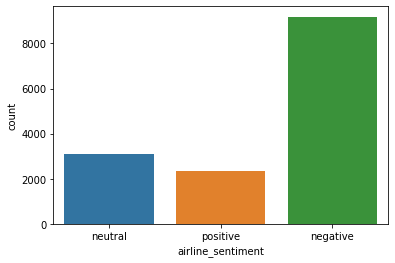

In [ ]:
# Unique values of sentiment plot
ax = sns.countplot(x="airline_sentiment", data=tweetsdf)

In [ ]:
tweetsdf['airline_sentiment'].replace({'neutral':0, 'negative':1, 'positive':2}, inplace=True)

Positive and neutral tweets are almost equal. Negative tweets are more than double of neutral or positive sentiments.

In [ ]:
df = tweetsdf[["clean_text","airline_sentiment"]]
df.shape

(14640, 2)

**Stop Word Removal**

In [ ]:
my_stops = stopwords.words('english') #loading all the stop words in english language provided by nltk package
stop_pat = r'\b(?:{})\b'.format('|'.join(my_stops)) # combining all the stop words by a delimiter '|' so that we can find
def removeStopWords(text):
  return re.sub(stop_pat, '', text) # remvoing all the stop words 

In [ ]:
df['nostop_words'] = df['clean_text'].apply(removeStopWords)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df['nostop_words']

0                                                    said 
1             plus   added commercials   experience tacky 
2                today must mean  need  take another trip 
3           really aggressive  blast obnoxious entertai...
4                                   really big bad thing  
                               ...                        
14635             thank   got   different flight  chicago 
14636     leaving  20 minutes late flight  warnings  co...
14637                     please bring american airlines  
14638        money  change  flight    answer  phones   ...
14639       8 ppl   need 2 know  many seats    next fli...
Name: nostop_words, Length: 14640, dtype: object

**Lemmatization**

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
# time consuming. takes around 1-2 mins to lemmatize entire corpus
def lemmatizing_tweets(text):
  doc = nlp(text)
  return " ".join([token.lemma_ for token in doc])

df['lemmatized_text'] = df['clean_text'].apply(lemmatizing_tweets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df['lemmatized_text'] 

0                                                 what say
1          plus -PRON- ve add commercial to the experie...
2          i didn t today must mean i need to take anot...
3          -PRON- s really aggressive to blast obnoxiou...
4          and -PRON- s a really big bad thing about -P...
                               ...                        
14635      thank -PRON- -PRON- get on a different fligh...
14636      leave over 20 minute late flight no warning ...
14637                     please bring american airline to
14638      -PRON- have -PRON- money -PRON- change -PRON...
14639      -PRON- have 8 ppl so -PRON- need 2 know how ...
Name: lemmatized_text, Length: 14640, dtype: object

In [ ]:
# time consuming. takes around 1-2 mins to lemmatize entire corpus
df['lemmatized_nostop_words'] = df['nostop_words'].apply(lemmatizing_tweets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# 3. Model having BERT Word Embedding with StopWords

In [ ]:
num_classes = 3 # 'neutral':0, 'negative':1, 'positive':2

In [ ]:
# take a peek at the data
df[['clean_text', 'airline_sentiment']].head().values

array([[' what said ', 0],
       [' plus you ve added commercials to the experience tacky ', 2],
       [' i didn t today must mean i need to take another trip ', 0],
       [' it s really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse',
        1],
       [' and it s a really big bad thing about it', 1]], dtype=object)

In [ ]:
clean_text = df['clean_text'].values.tolist()
airline_sentiment = df['airline_sentiment'].values.tolist()

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(clean_text,airline_sentiment, test_size = 0.25, random_state = 42)
len(train_x),len(test_x),len(train_y),len(test_y)

(10980, 3660, 10980, 3660)

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def bert_tokenizer(data):
  encoding = tokenizer.batch_encode_plus(data,padding=True)
  return tf.constant(encoding['input_ids'])

In [ ]:
train_tokenized = bert_tokenizer(train_x)
test_tokenized = bert_tokenizer(test_x)

In [ ]:
batch_size=32

In [ ]:
# convert class vectors to binary class matrices- one hot encoding
from tensorflow import keras

y_train = keras.utils.to_categorical(train_y, num_classes)
y_test = keras.utils.to_categorical(test_y, num_classes)

In [ ]:
# building tensorflow data input pipeline

# extract, transform, load
train_dataset =(
    tf.data.Dataset
    .from_tensor_slices((train_tokenized, y_train)) # extracting the data
    .shuffle(128) # randomly shuffle the entries with buffer size of 128
    .batch(batch_size) # required to run training model in multiple GPU
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_tokenized, y_test))
    .shuffle(128)
    .batch(batch_size)
)

In [ ]:
def build_bertmodel():
    word_inputs = tf.keras.Input(shape=(None,),dtype=tf.int32)
    last_hidden_states = bert_model(word_inputs)[0]
    x = tf.keras.layers.SpatialDropout1D(0.2)(last_hidden_states)
    x = tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2))(x)
    x = tf.keras.layers.Dense(128, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(word_inputs, outputs)
    return model

In [ ]:
base_bertmodel = build_bertmodel()
base_bertmodel.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

base_bertmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             None, 768),                         
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [ ]:

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-5, patience=5)]

In [ ]:
history = base_bertmodel.fit(
    train_dataset,
    batch_size=128,
    epochs=4,
    validation_data=test_dataset,
    verbose=1,
    callbacks = callbacks)

Epoch 1/4
344/344 [==============================] - 110s 246ms/step - loss: 0.9543 - accuracy: 0.6111 - val_loss: 0.9089 - val_accuracy: 0.6393 - lr: 0.0010
Epoch 2/4
344/344 [==============================] - 80s 233ms/step - loss: 0.9320 - accuracy: 0.6228 - val_loss: 0.9048 - val_accuracy: 0.6393 - lr: 0.0010
Epoch 3/4
344/344 [==============================] - 80s 233ms/step - loss: 0.9279 - accuracy: 0.6228 - val_loss: 0.9026 - val_accuracy: 0.6393 - lr: 0.0010
Epoch 4/4
344/344 [==============================] - 80s 233ms/step - loss: 0.9270 - accuracy: 0.6228 - val_loss: 0.9032 - val_accuracy: 0.6393 - lr: 0.0010


# 4. XLNet Word Embedding with StopWords

In [ ]:
from numpy.core.fromnumeric import size

xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = TFXLNetModel.from_pretrained('xlnet-base-cased')

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [ ]:
max_len = 120

In [ ]:
def xlnet_encode(text):
  train_tokenized = xlnet_tokenizer.batch_encode_plus(text,max_length= max_len, padding='max_length',return_tensors="pt")
  return tf.constant(train_tokenized['input_ids'])

In [ ]:
train_encoded = xlnet_encode(train_x)
test_encoded = xlnet_encode(test_x)

In [ ]:
y_train = keras.utils.to_categorical(train_y, num_classes)
y_test = keras.utils.to_categorical(test_y, num_classes)

In [ ]:
batch_size=32

In [ ]:
train_xlnet_dataset =(
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(128)
    .batch(batch_size)
)

test_xlnet_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_encoded, y_test))
    .shuffle(128)
    .batch(batch_size)
)

In [ ]:
def build_xlnetmodel():
  word_inputs = tf.keras.Input(shape=(max_len,), dtype='int32')

  # Call XLNet model
  xlnet_encodings = xlnet_model(word_inputs)[0]
  doc_encoding = tf.keras.layers.SpatialDropout1D(0.2)(xlnet_encodings)
  x = tf.keras.layers.Bidirectional(LSTM(25, dropout=0.2, recurrent_dropout=0.2))(doc_encoding)

  # Final output 
  outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='outputs')(x)

  # Compile model
  model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
  model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
base_xlmodel = build_xlnetmodel()
base_xlmodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120)]             0         
                                                                 
 tfxl_net_model (TFXLNetMode  TFXLNetModelOutput(last_  116718336
 l)                          hidden_state=(None, 120,            
                              768),                              
                              mems=((120, None, 768),            
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),            

In [ ]:
def warmup(epoch, lr):
    """Used for increasing the learning rate slowly, this tends to achieve better convergence.
    However, as we are finetuning for few epoch it's not crucial.
    """
    return max(lr +1e-6, 2e-5)


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.02, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [ ]:
history = base_xlmodel.fit(
    train_xlnet_dataset,
    batch_size=batch_size,
    epochs=1,
    validation_data=test_xlnet_dataset,
    verbose=1,
    callbacks = callbacks)

344/344 [==============================] - 654s 2s/step - loss: 0.9359 - accuracy: 0.6175 - val_loss: 0.9027 - val_accuracy: 0.6393 - lr: 0.0010


# 5. Model having BERT Word Embedding without StopWords

In [ ]:
# take a peek at the data
df[['nostop_words', 'airline_sentiment']].head().values

array([['  said ', 0],
       [' plus   added commercials   experience tacky ', 2],
       ['    today must mean  need  take another trip ', 0],
       ['   really aggressive  blast obnoxious entertainment   guests faces amp   little recourse',
        1],
       ['     really big bad thing  ', 1]], dtype=object)

In [ ]:
nostop_words = df['nostop_words'].values.tolist()
airline_sentiment = df['airline_sentiment'].values.tolist()

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(nostop_words,airline_sentiment, test_size = 0.25, random_state = 42)
len(train_x),len(test_x),len(train_y),len(test_y)

(10980, 3660, 10980, 3660)

In [ ]:
train_tokenized_nostop = bert_tokenizer(train_x)
test_tokenized_nostop = bert_tokenizer(test_x)

In [ ]:
y_train = keras.utils.to_categorical(train_y, num_classes)
y_test = keras.utils.to_categorical(test_y, num_classes)

In [ ]:
batch_size=32

In [ ]:
# building tensorflow data input pipeline

# extract, transform, load
train_dataset_nostop =(
    tf.data.Dataset
    .from_tensor_slices((train_tokenized_nostop, y_train)) # extracting the data
    .shuffle(128) # randomly shuffle the entries with buffer size of 128
    .batch(batch_size) # required to run training model in multiple GPU
)

test_dataset_nostop = (
    tf.data.Dataset
    .from_tensor_slices((test_tokenized_nostop, y_test))
    .shuffle(128)
    .batch(batch_size)
)

In [ ]:
bertmodel_nostop = build_bertmodel()

bertmodel_nostop.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

bertmodel_nostop.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             None, 768),                         
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

In [ ]:
bertmodel_nostop.fit(
    train_dataset_nostop,
    batch_size=batch_size,
    epochs=1,
    validation_data=test_dataset_nostop,
    verbose=1,
    callbacks = callbacks)

344/344 [==============================] - 226s 599ms/step - loss: 0.9263 - accuracy: 0.6209 - val_loss: 0.9025 - val_accuracy: 0.6393 - lr: 0.0010


# 6. Model having XLNet Word Embedding without StopWords

In [ ]:
train_encode_xlnetnostop = xlnet_encode(train_x)
test_encode_xlnetnostop = xlnet_encode(test_x)

In [ ]:
batch_size=32

In [ ]:
train_dataset_xlent_nostop =(
    tf.data.Dataset
    .from_tensor_slices((train_encode_xlnetnostop, y_train))
    .shuffle(128)
    .batch(batch_size)
)

test_dataset_xlent_nostop = (
    tf.data.Dataset
    .from_tensor_slices((test_encode_xlnetnostop, y_test))
    .shuffle(128)
    .batch(batch_size)
)

In [ ]:
xlnetModel_nostop = build_xlnetmodel()
xlnetModel_nostop.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 120)]             0         
                                                                 
 tfxl_net_model (TFXLNetMode  TFXLNetModelOutput(last_  116718336
 l)                          hidden_state=(None, 120,            
                              768),                              
                              mems=((120, None, 768),            
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),            

In [ ]:
xlnetModel_nostop.fit(
    train_dataset_xlent_nostop,
    batch_size=batch_size,
    epochs=1,
    validation_data=test_dataset_xlent_nostop,
    verbose=1,
    callbacks = callbacks)

344/344 [==============================] - 657s 2s/step - loss: 0.9290 - accuracy: 0.6192 - val_loss: 0.9027 - val_accuracy: 0.6393 - lr: 0.0010


Summarizing Performace of the Models so far.
```

+-----------------------------------------------------+----------+
|                 Parameter Settings                  | Accuracy |
+-----------------------------------------------------+----------+
| BERT Word Embedding + StopWords                     | 64%      |
| XLNet Word Embedding + StopWords                    | 64%      |
| BERT Word Embedding + No StopWords                  | 64%      |
| XLNet Word Embedding + No StopWords                 | 64%      |
+-----------------------------------------------------+----------+
```
From the above Stats, all the models have similar performace hence we can choose any of the models for further training. Using `XLNet Model with Stop Words` to train the model with lemmatization.




# 7. Model having XLNet Word Embedding with Lemmatization + with Stop Words

In [ ]:
# take a peek at the data
df[['lemmatized_text', 'airline_sentiment']].head().values

array([['  what say', 0],
       ['  plus -PRON- ve add commercial to the experience tacky', 2],
       ['  i didn t today must mean i need to take another trip', 0],
       ['  -PRON- s really aggressive to blast obnoxious entertainment in -PRON- guest face amp -PRON- have little recourse',
        1],
       ['  and -PRON- s a really big bad thing about -PRON-', 1]],
      dtype=object)

In [ ]:
lemmatized_text = df['lemmatized_text'].values.tolist()
airline_sentiment = df['airline_sentiment'].values.tolist()

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(clean_text,airline_sentiment, test_size = 0.25, random_state = 42)
len(train_x),len(test_x),len(train_y),len(test_y)

(10980, 3660, 10980, 3660)

In [ ]:
train_xlnet_lemmatized = xlnet_encode(train_x)
test_xlnet_lemmatized = xlnet_encode(test_x)

In [ ]:
batch_size=32

In [ ]:
train_xlnet_lemmatized_dataset =(
    tf.data.Dataset
    .from_tensor_slices((train_xlnet_lemmatized, y_train))
    .shuffle(128)
    .batch(batch_size)
)

test_xlnet_lemmatized_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_xlnet_lemmatized, y_test))
    .shuffle(128)
    .batch(batch_size)
)

In [ ]:
lemmatized_xlmodel = build_xlnetmodel()
lemmatized_xlmodel.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 120)]             0         
                                                                 
 tfxl_net_model (TFXLNetMode  TFXLNetModelOutput(last_  116718336
 l)                          hidden_state=(None, 120,            
                              768),                              
                              mems=((120, None, 768),            
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),            

In [ ]:
callbacks2 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.02, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [ ]:
lemmatized_xlmodel.fit(
    train_xlnet_lemmatized_dataset,
    batch_size=batch_size,
    epochs=1,
    validation_data=test_xlnet_lemmatized_dataset,
    verbose=1,
    callbacks = callbacks2)

344/344 [==============================] - 657s 2s/step - loss: 0.9265 - accuracy: 0.6214 - val_loss: 0.9022 - val_accuracy: 0.6393 - lr: 0.0010


Conclusion: Comparing accuracies of all the models
```

+--------------------------------------------------+----------+
|                parameter settings                | Accuracy |
+--------------------------------------------------+----------+
| BERT Word Embedding + StopWords                  | 64%      |
| XLNet Word Embedding + StopWords                 | 64%    |
| BERT Word Embedding + No StopWords               | 64%      |
| XLNet Word Embedding + No StopWords              | 64%      |
| XLNet Word Embedding + StopWords + Lemmatization | 64%      |
+--------------------------------------------------+----------+
```
all the models are having similar performance with accuracy of 64%.

#8. HyperParameter Tuning - batch size and number of epochs

---



In [ ]:
word_inputs = tf.keras.Input(shape=(None,), dtype='int32')
# Call XLNet model
xlnet_encodings = xlnet_model(word_inputs)[0]
doc_encoding = tf.keras.layers.SpatialDropout1D(0.5)(xlnet_encodings)
x = tf.keras.layers.Bidirectional(LSTM(25, dropout=0.5, recurrent_dropout=0.5))(doc_encoding)

# Final output 
outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='outputs')(x)

# Compile modela
model1 = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
model1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 tfxl_net_model (TFXLNetMode  multiple                 116718336 
 l)                                                              
                                                                 
 spatial_dropout1d_7 (Spatia  (None, None, 768)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_7 (Bidirectio  (None, 50)               158800    
 nal)                                                            
                                                                 
 outputs (Dense)             (None, 3)                 153       
                                                           

In [ ]:
base_xlmodel.fit(
    train_xlnet_dataset,
    batch_size=64,
    epochs=1,
    validation_data=test_xlnet_dataset,
    verbose=1,
    callbacks = callbacks)

344/344 [==============================] - 637s 2s/step - loss: 0.9211 - accuracy: 0.6228 - val_loss: 0.9019 - val_accuracy: 0.6393 - lr: 0.0010


In [ ]:
base_xlmodel.fit(
    train_xlnet_dataset,
    batch_size=128,
    epochs=1,
    validation_data=test_xlnet_dataset,
    verbose=1,
    callbacks = callbacks)

344/344 [==============================] - 638s 2s/step - loss: 0.9211 - accuracy: 0.6228 - val_loss: 0.9022 - val_accuracy: 0.6393 - lr: 0.0010


In [ ]:
base_xlmodel.fit(
    train_xlnet_dataset,
    batch_size=256,
    epochs=1,
    validation_data=test_xlnet_dataset,
    verbose=1,
    callbacks = callbacks)

344/344 [==============================] - 635s 2s/step - loss: 0.9211 - accuracy: 0.6228 - val_loss: 0.9024 - val_accuracy: 0.6393 - lr: 0.0010


#9. Predictions

In [ ]:
# importing data set
corpus_root = '/content/drive/Othercomputers/My Laptop/syr_ads_ist664/hw03/covid_data.json' # will have to replace this value with your data set file path

# data set is a json file with multiple json object hence iterating over each json object to extract the news/blogs
json_list = []
with open(corpus_root,encoding='utf8') as file_handler:
    for json_obj in file_handler:
        data = json.loads(json_obj)
        json_list.append(data)

In [ ]:
covid_df = pd.DataFrame(json_list)

In [ ]:
# viewing first 5 rows to undertand the dataset
covid_df.head(2)

,organizations,uuid,thread,author,url,ord_in_thread,title,locations,entities,highlightText,language,persons,text,external_links,published,crawled,highlightTitle
0,[],0ad32fb9226b172b960cba62027cd8be7d9dfa22,"{'social': {'gplus': {'shares': 0}, 'pinterest...",Udayavani,https://m.dailyhunt.in/news/india/english/uday...,0,"Karnataka: Helplines, isolation wards set up f...",[],"{'persons': [], 'locations': [{'name': 'karnat...",,english,[],Bengaluru: Isolation wards in hospitals across...,[],2020-01-31T11:46:00.000+02:00,2020-01-31T17:18:04.007+02:00,
1,[],8c3c1e13471a5e6ef7e115588ab27f308285cf2e,"{'social': {'gplus': {'shares': 0}, 'pinterest...",,http://cnnphilippines.com/videos/2020/1/28/Hea...,0,Health dept. monitoring 24 people for possible...,[],"{'persons': [], 'locations': [{'name': 'hubei'...",,english,[],The government making sure that the new corona...,[],2020-01-28T02:00:00.000+02:00,2020-01-31T06:38:31.000+02:00,


In [ ]:
def get_inputs(sent, tokenizer):
    inps = tokenizer.encode_plus(sent, padding='max_length', max_length=max_len) 
    inp_tok = np.array([inps['input_ids']])
    return inp_tok

In [ ]:
covid_df['text'] = covid_df['text'].apply(str.lower) # data pre-processing
tempdf = covid_df.iloc[:200]

In [ ]:
tempdf.shape

(200, 17)

In [ ]:
nltk.download('punkt')
# iterating over each news article to predict the sentiment
for index,row in tempdf.iterrows():
  sents = nltk.sent_tokenize(row['text'])
  num_pos_score = 0
  num_neg_score = 0
  num_neutral_score = 0
  for sent in sents:
    print(sent)
    try:
      encoding = get_inputs(sent,xlnet_tokenizer)  
      pred_arr = base_xlmodel.predict(encoding, verbose=False) # predicting the sentiment
      # picking the array index having highest probability
      argIndex = np.argmax(pred_arr[0],axis=-1) 
    except:
      continue
    if argIndex == 2:
        num_pos_score = num_pos_score + 1
    elif argIndex == 1:
        num_neg_score = num_neg_score + 1
    elif argIndex == 0:
        num_neutral_score = num_neutral_score + 1       
  tempdf.loc[index, 'the number of positive sentences'] = num_pos_score
  tempdf.loc[index, 'the number of negative sentences'] = num_neg_score
  tempdf.loc[index, 'the number of neutral sentences'] = num_neutral_score

In [ ]:
# writing the output to csv
tempdf.to_csv('/content/drive/Othercomputers/My Laptop/syr_ads_ist664/hw03/chaithra_kopparam_cheluvaiah_out.csv')

External Sources Used:

https://www.youtube.com/watch?v=VFEOskzhhbc 

https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/44_tf_data_pipeline/tf_data_pipeline.ipynb 

https://www.kaggle.com/code/rihab147/xlnet-tunisian-sentiment-analysis/notebook 

https://www.kaggle.com/code/dhruv1234/huggingface-tfbertmodel/notebook 

https://www.kaggle.com/code/christofhenkel/bert-embeddings-lstm/notebook 